In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skibidi_face_detector.dataset.small_celebrities import train_loader
from skibidi_face_detector.face_embedder.Model import Model
from resources.model import MODEL_FILE, MODEL_PARAMS

In [2]:
model = Model.load_from_checkpoint(MODEL_FILE, **MODEL_PARAMS)
model.transformer = None
model.augments = None
model.eval()

Model(
  (embedder): Embedder(
    (feature_extractor): Sequential(
      (0): VggFace2(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [3]:
X = []
Y = []

for batch in tqdm(train_loader):
    x, y = model.transform_batch(batch)
    with torch.inference_mode():
        embeddings = model(x)

    X.append(embeddings.cpu())
    Y.append(y.cpu())

100%|██████████| 75/75 [04:39<00:00,  3.73s/it]


In [4]:
for _x, _y in zip(X, Y):
    print(_x)
    print(_y)
    break

tensor([[-0.2215,  0.0984, -0.3249,  ...,  0.0528,  0.2441,  0.1044],
        [ 0.6309,  0.2475, -0.2607,  ..., -0.1231, -0.1167,  0.1824],
        [-0.1034,  0.3459, -0.0696,  ...,  0.0257, -0.0835, -0.3288],
        ...,
        [ 0.5796, -0.0666, -0.2759,  ..., -0.1204, -0.3926,  0.1387],
        [-0.2692,  0.0163,  0.1774,  ...,  0.2884,  0.1417,  0.0028],
        [ 0.3993, -0.2496, -0.3899,  ..., -0.3542, -0.2354,  0.0384]])
tensor([ 66,  52,  62,  38,   5,  66,  23,  68,  57,  25,  84,  38,  28,   3,
         99,  38,  71,  11,  42,  76,  27,  72,  75,  17,  77,  10,  42,  19,
        102,  13])


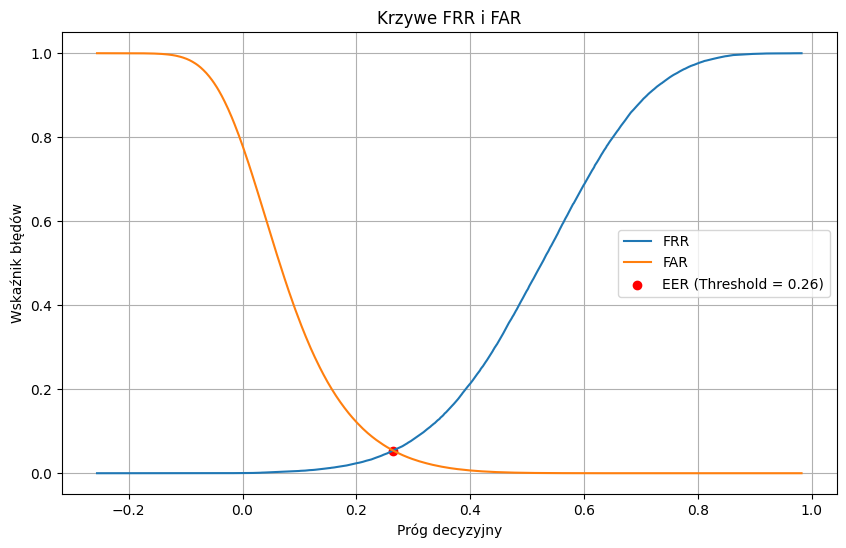

In [5]:
X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0)

normalized_X = torch.nn.functional.normalize(X, p=2, dim=1)

similarity_matrix = torch.mm(normalized_X, normalized_X.T)


n_samples = X.size(0)
i, j = torch.triu_indices(n_samples, n_samples, offset=1)

mask_genuine = (Y[i] == Y[j])

genuine_scores = similarity_matrix[i[mask_genuine], j[mask_genuine]].numpy()
impostor_scores = similarity_matrix[i[~mask_genuine], j[~mask_genuine]].numpy()


min_score = min(genuine_scores.min(), impostor_scores.min())
max_score = max(genuine_scores.max(), impostor_scores.max())
thresholds = np.linspace(min_score, max_score, 1000)

frr = [np.mean(genuine_scores < t) for t in thresholds]
far = [np.mean(impostor_scores >= t) for t in thresholds]


eer_index = np.argmin(np.abs(np.array(frr) - np.array(far)))
eer_threshold = thresholds[eer_index]
eer_value = (frr[eer_index] + far[eer_index]) / 2

plt.figure(figsize=(10, 6))
plt.plot(thresholds, frr, label="FRR")
plt.plot(thresholds, far, label="FAR")
plt.scatter(eer_threshold, eer_value, color="red", label=f"EER (Threshold = {eer_threshold:.2f})")
plt.xlabel("Próg decyzyjny")
plt.ylabel("Wskaźnik błędów")
plt.legend()
plt.title("Krzywe FRR i FAR")
plt.grid(True)
plt.show()